<a href="https://colab.research.google.com/github/bereml/riiaa-19-dmtl/blob/master/notebooks/1_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón multicapa

#### <div style="text-align: right"> Berenice Montalvo Lezama </div>

En este ejemplo veremos como implementar un perceptrón multicapa para la tarea de clasificación de imágenes. Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Tiene imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.

![MNIST](https://raw.githubusercontent.com/richardtml/riiaa-19-dmtl/master/figs/mnist.png)

## 1 Carga de datos

### 1.1 Importando bibliotecas

In [1]:
# para cargar Tensorflow 2 en Colab
try:
  %tensorflow_version 2.x
except Exception:
  pass

# graficación
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model

# fijamos una semilla para reproducibilidad
tf.random.set_seed(2019)

### 1.2 Descarga de los datos
Comenzaremos descargando y leyendo el conjunto de datos. Aprovecharemos que Tensorflow cuenta con utilerias en el paquete [`tf.keras.datasets`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/datasets) para descargar algunos conjuntos de datos de referencia preprocesados.

In [2]:
# alias
mnist = tf.keras.datasets.mnist
# descarga
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### 1.3 Visualización

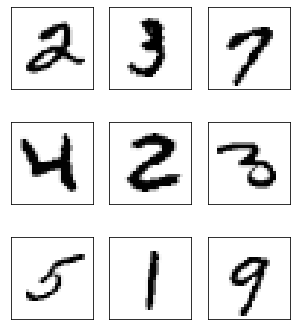

In [3]:
plt.figure(figsize=(5, 6))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[5 * i], cmap='Greys')

### 1.4 Normalización

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = y_train[..., tf.newaxis]
y_test = y_test[..., tf.newaxis]

### 1.5 Tuberia de datos

![Pipeline](https://raw.githubusercontent.com/richardtml/riiaa-19-dmtl/master/figs/pipeline.png)

In [5]:
batch_size = 64
# Cargamor en un Dataset
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# lo barajeamos
ds = ds.shuffle(60000)
# empaquetamos los lotes
ds = ds.batch(batch_size)

# exploremos
for x, y_true in ds:
    print('x.shape={}'.format(x.shape))
    print('x={}'.format(x.numpy().flatten()))
    print('y_true.shape={}'.format(y_true.shape))
    print('y={}'.format(y_true.numpy().flatten()))
    break

W0829 22:50:26.545773 140715154745152 deprecation.py:323] From /home/bere/.virtualenvs/cap/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


x.shape=(64, 28, 28)
x=[0. 0. 0. ... 0. 0. 0.]
y_true.shape=(64, 1)
y=[2 6 0 7 8 7 5 7 7 4 4 4 3 2 3 7 7 6 3 7 0 3 1 3 1 6 1 3 1 0 6 4 9 9 4 0 5
 9 8 8 0 9 2 1 6 1 3 0 7 6 7 0 1 8 7 7 1 7 3 7 9 7 0 3]


### Quiz 1

¿Cúal es la función de activación adecuada para la capa de salida de una red neuronal para clasificación multiclase?

## 2 Definición del modelo

### 2.1 implementación

In [6]:
# se define una clase que hereda de tensorflow.keras.Moldel
class MLP(Model):
    
    #se define el inicializador
    def __init__(self):
        # se llama al inicializador de la clase padre
        super(MLP, self).__init__()
        # importante: se definen las capas como atributos de la clase
        # Flatten aplana tensores
        self.flatten = Flatten()
        # Dense es un capa completamente conectada donde
        # units es el número de neuronas y
        # activation es la función de activación
        self.fc1 = Dense(units=128, activation=tf.nn.relu)
        self.fc2 = Dense(units=10, activation=tf.nn.softmax)

    # se realiza inferencia y definición de arquitectura al vuelo
    def call(self, x):
        # (N, 28, 28) =>
        # (N, 28*28)
        o = self.flatten(x)
        # (N, 28*28) =>
        # (N, 128)
        o = self.fc1(o)
        # (N, 128) =>
        # (N, 10)
        o = self.fc2(o)
        return o

### Quiz 2

Si las clases fueran 100 en vez de 10 y quisera utilizar la misma arquitectura anterior ¿qué modificación tendría que realizar? 

### 2.2 Definición de pérdida y optimizador

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

### 2.3 Definición de métricas

Las clases dentro de `tf.keras.metrics` están diseñadas para mantener un histórico de una métrica a lo largo de los pasas de entrenamiento y agregarlo (con el promedio por ejemplo) para obtener el desempeño de la métrica a nivel epoca.

In [8]:
# historiales a nivel época
loss_epoch = tf.keras.metrics.SparseCategoricalCrossentropy()
acc_epoch = tf.keras.metrics.SparseCategoricalAccuracy()

# historiales a nivel entrenamiento
loss_history = []
acc_history = []

## 3 Entrenamiento

### 3.1 Ciclo de entrenamiento

In [9]:
# instanciamos nuestro modelo
model = MLP()

epochs = 25
# épocas de entrenamiento
for epoch in range(epochs):
    
    # pasos de entrenamiento
    for x, y_true in ds:
        
        # registramos el flujo del cómputo en GradientTape
        with tf.GradientTape() as tape:
            
            # realizamos inferencia con el lote
            y_pred = model(x)
            
            # realizamos inferencia con el lote
            loss = loss_fn(y_true, y_pred)            
        
        # computamos los gradientes de los parámetros del modelo
        gradients = tape.gradient(loss, model.trainable_variables)
        
        # aplicamos los gradientes
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # calculamos las métricas y agramos al historial de la época
        loss_epoch(y_true, y_pred)
        acc_epoch(y_true, y_pred)
    
    # guardamos las métricas de la época
    loss_res = loss_epoch.result().numpy() * 100
    acc_res = acc_epoch.result().numpy() * 100
    
    # reiniciamos los historiales de las épocas
    loss_epoch.reset_states()
    acc_epoch.reset_states()
    
    # agreagmos a los historiales nivel entrenamiento
    loss_history.append(loss_res)
    acc_history.append(acc_res)

    # imprimimos métricas
    print('{:3d} loss={:6.2f}, acc={:6.2f}'.format(epoch, loss_res, acc_res))        

  0 loss=194.70, acc= 44.45
  1 loss=137.57, acc= 72.60
  2 loss=102.29, acc= 79.43
  3 loss= 82.57, acc= 82.48
  4 loss= 70.85, acc= 84.18
  5 loss= 63.23, acc= 85.27
  6 loss= 57.89, acc= 86.06
  7 loss= 53.94, acc= 86.73
  8 loss= 50.89, acc= 87.23
  9 loss= 48.46, acc= 87.65
 10 loss= 46.47, acc= 87.99
 11 loss= 44.81, acc= 88.33
 12 loss= 43.40, acc= 88.58
 13 loss= 42.18, acc= 88.82
 14 loss= 41.11, acc= 89.04
 15 loss= 40.16, acc= 89.22
 16 loss= 39.32, acc= 89.36
 17 loss= 38.56, acc= 89.54
 18 loss= 37.87, acc= 89.67
 19 loss= 37.23, acc= 89.83
 20 loss= 36.65, acc= 89.96
 21 loss= 36.11, acc= 90.07
 22 loss= 35.61, acc= 90.21
 23 loss= 35.15, acc= 90.33
 24 loss= 34.71, acc= 90.43


### 3.2 Gráfica de la pérdida

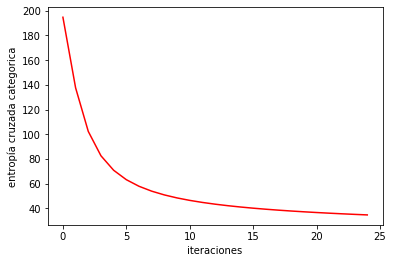

In [10]:
plt.plot(np.arange(len(loss_history)), loss_history, color='red')
plt.xlabel('iteraciones')
plt.ylabel('entropía cruzada categorica')
plt.show()

### 3.3 Gráfica la exactitud

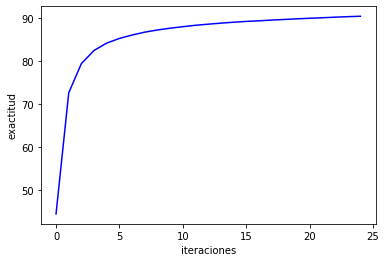

In [11]:
plt.plot(np.arange(len(acc_history)), acc_history, color='blue')
plt.xlabel('iteraciones')
plt.ylabel('exactitud')
plt.show()

## 4 Validación

### 4.1 Exactitud

In [12]:
y_pred_test = model(x_test)
print(acc_epoch(y_test, y_pred_test).numpy() * 100)

91.10000133514404


### 4.2 Inferencia

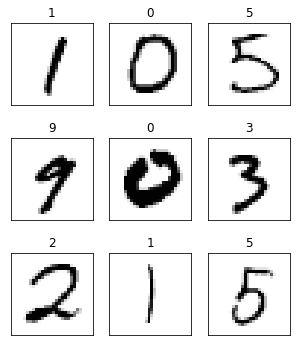

In [13]:
plt.figure(figsize=(5, 6))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[5*i], cmap='Greys')
    plt.title(y_pred_test[5*i].numpy().argmax())